In [1]:
# rates and rate ratios

In [2]:
import pandas as pd
import pickle
import pysal as ps
import geopandas as gpd
from geopandas import GeoDataFrame
import geopy
import xlrd
from ukpostcodeutils import validation
from scipy.special import ndtri
from scipy.stats import chi2
from math import sqrt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from tqdm import tqdm
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from tqdm import tqdm

%matplotlib inline


/home/drcjar/anaconda3/envs/gds/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [3]:
infile = open('df','rb')
df = pickle.load(infile)
infile.close()

infile = open('dcut','rb')
dcut = pickle.load(infile)
infile.close()

infile = open('areacut','rb')
areacut = pickle.load(infile)
infile.close()

infile = open('rural_nsyc_vs_syc','rb')
rural_nsyc_vs_syc = pickle.load(infile)
infile.close()

infile = open('urban_nsyc_vs_syc','rb')
urban_nsyc_vs_syc = pickle.load(infile)
infile.close()

infile = open('rural_coastal_syc_vs_rural_coastal_nsyc','rb')
rural_coastal_syc_vs_rural_coastal_nsyc = pickle.load(infile)
infile.close()

infile = open('urban_coastal_syc_vs_urban_coastal_nsyc','rb')
urban_coastal_syc_vs_urban_coastal_nsyc = pickle.load(infile)
infile.close()


infile = open('coastal_nsyc_vs_syc','rb')
coastal_nsyc_vs_syc = pickle.load(infile)
infile.close()


l = dict(zip(['cr', 'ar', 'ds', 'smr'], [i for i in range(0,4)]))
l2 = dict(zip(['cr2', 'ar2', 'ds2', 'smr2', 'da2'], [i for i in range(0,5)]))

# dcut is dockyard cuts
# areacut is area cuts
# cr = crude rate, ar = age-adjusted rate, ds = directly standardised rate, smr= indirect smr
# da = dockyard analysis

In [4]:
areacut.keys() 
# check numbers / method
# add coastal lads, non-coastal lads, coastal lad with dock, coastal lad without dock, urban/rural
# repeat for smaller unit of analysis? (see more-mapping-mesothelioma )
# see mapping-mesothelioma for linear regression and morans. try and add ci to morans. consider multiple regression.
# rv/compare with, site US paper

dict_keys(['all-years', 'men-only', 'women-only', 'pre-2009', 'post-2009', 'men-only pre-2009', 'men-only post-2009', 'women-only pre-2009', 'women-only post-2009'])

In [5]:
def lad_dist_to_coast():
    """
    lads that touch the coastline
    """
    
    # lad geo data
    lads = gpd.read_file('lads.json')
    lads.crs = {'init': 'epsg:4326'}
    lads.rename(index=str, columns={"lad16cd": "LAD16CD"}, inplace=True)

    # we obtain a country boundary file from gov geoportal (the UK)
    c = gpd.read_file('country2.json')
    c.crs = {'init': 'epsg:4326'}

    # UK projection for the UK
    c = c.to_crs(epsg=27700)
    lads = lads.to_crs(epsg=27700)

    # England and Wales Map
    ew = c[c['ctry17nm'] != 'Scotland'] 
    lads = lads[lads.LAD16CD.str[:1] != 'S']
    
    # lets not have borders inside our country so that distance to border == distance to coast
    ew = ew.dissolve(by='extrude')
    
    # UK projection for the UK
    ew = ew.to_crs(epsg=27700)

    # LAD geodataframe
    df = GeoDataFrame(lads)
    df.crs = {'init': 'epsg:27700'} 

    # distance to coast in km
    df['dist_to_coast'] = df.geometry.map(lambda x: x.distance(ew.boundary[0]))
    df['dist_to_coast_in_km'] =  df['dist_to_coast'] / 1000
    
    return df

coastlad = lad_dist_to_coast()
coastlad[coastlad['dist_to_coast_in_km'] < 1]['LAD16CD'].values # lads within 1km of coast
df['coastlad'] = df['LAD16CD'].isin(coastlad['LAD16CD']) # this is fine but could be misleading for smaller area
# units because df only contains area units with >0 meso deaths

def docksinarea(area, areacd):
    gdf = gpd.read_file('docks_edited.geojson')
    gdf = gdf.to_crs(epsg=4326)
    gdf.crs = {'init': 'epsg:4326'}
    located_docks = gpd.sjoin(gdf, area[[areacd, 'geometry']].copy(), op='within')
    n_docks_not_located = len(gdf[~gdf.name.isin(located_docks.name)])
    print("\n{} docks not located".format( n_docks_not_located))
    return located_docks

def add_missing_lsoa_docks(lsoadocks):
    located_docks = lsoadocks
    
    gdf = gpd.read_file('docks_edited.geojson')
    gdf = gdf.to_crs(epsg=4326)
    gdf.crs = {'init': 'epsg:4326'}
    
    # we manually add docks that failed to be located (cos their points weren't in the polygon)
    
    missing = gdf[~gdf.name.isin(located_docks.name)].copy()
 
    dock_lsoa_lookup = { "Hay's Wharf": 'E01004027',
                         'New Holland': 'E01013303',
                         'Glasson Dock': 'E01025107',
                         'Marshall Dock': 'E01019126',
                         'Greenfield Dock': 'W01000296'}

    missing.loc[:, 'LSOA11CD'] = missing.loc[:, 'name'].map(dock_lsoa_lookup)

    lookup = pd.read_csv('Lower_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv')
    missing = pd.merge(missing, lookup.drop_duplicates(subset='LSOA11CD'), on='LSOA11CD')

    missing = missing[['timestamp', 'version', 'changeset', 'user', 'uid', 'name',
           'source', 'waterway', 'id', 'access_tid', 'landuse', 'natural',
           'seamark_ha', 'seamark_ty', 'wikidata', 'source_nam', 'source_geo',
           'dock', 'note', 'boat', 'leisure', 'phone', 'wikipedia',
           'alt_name', 'OnroerendE', 'heritage', 'heritage_o', 'heritage_w',
           'ref_Onroer', 'water', 'tidal', 'old_name', 'access_t_1', 'fax',
           'harbour', 'harbour_bo', 'harbour__1', 'harbour__2', 'harbour_ca',
           'harbour_ch', 'harbour_el', 'harbour_fu', 'harbour_la',
           'harbour_ph', 'harbour_pr', 'harbour_pu', 'harbour_re',
           'harbour_sh', 'harbour_to', 'harbour_vi', 'harbour_wa',
           'internet_a', 'internet_1', 'internet_2', 'operator', 'sanitary_d',
           'seamark_in', 'seamark_na', 'vhf_channe', 'website', 'addr_city',
           'bezier', 'descriptio', 'area', 'created_by', 'name_en',
           'building', 'lock', 'loc_name', 'ship', 'man_made', 'ref',
           'mooring', 'email', 'harbour_sc', 'layer', 'width', 'source_sha',
           'start_date', 'image', 'ref_rce', 'designatio', 'maxdraught',
           'maxlength', 'maxwidth', 'type', 'floating', 'name_gv', 'tourism',
           'architect', 'historic', 'info', 'surveillan', 'maxstay',
           'addr_stree', 'motorboat', 'mhs_inscri', 'ref_mhs', 'source_her',
           'access', 'covered', 'maxdraft', 'capacity', 'contact_ph',
           'harbour_in', 'index_righ', 'tessellate', 'extrude', 'visibility',
           'ctry17cd', 'ctry17nm', 'ctry17nmw', 'bng_e', 'bng_n', 'long',
           'lat', 'objectid', 'st_lengths', 'st_areasha', 'dist_to_co',
           'geometry', 'LSOA11CD']]

    del located_docks['index_right']
    located_docks = pd.concat([located_docks, missing], sort=True)
    
    n_docks_not_located = len(gdf[~gdf.name.isin(located_docks.name)])
    
    print("\n*missing docks added* now {} docks not located".format( n_docks_not_located))
    
    return located_docks

lsoa = gpd.read_file('lsoa.json')
lsoa.crs = {'init': 'epsg:4326'}
lsoa.rename(index=str, columns={"lsoa11cd": "LSOA11CD"}, inplace=True)

area = lsoa
areacd = 'LSOA11CD'
lsoadocks = docksinarea(area, areacd)
lsoadocks = add_missing_lsoa_docks(lsoadocks)

lookup = pd.read_csv('Lower_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv')
docks = pd.merge(lsoadocks, lookup, on='LSOA11CD')  # now each dock has lsoa, ward, and lad

# checking docks we have against our geojson 4 are missing
# we add manually
gdf = gpd.read_file('docks_edited.geojson')
gdf = gdf.to_crs(epsg=4326)
gdf.crs = {'init': 'epsg:4326'}
missing = gdf[~gdf.id.isin(docks.id)].copy()
missing.loc[42,'LSOA11CD'] = 'E01021057'
missing.loc[43,'LSOA11CD'] = 'E01021047'
missing.loc[114,'LSOA11CD'] = 'E01013136'
missing.loc[180,'LSOA11CD'] = 'E01033104'
docks = pd.concat([docks, missing], sort=True)
docks = docks.to_crs(epsg=27700)

import scipy.stats as stats
import statsmodels.api as sm
import numpy as np

def logitmodel(df):
    X = df['docks'].astype(int)
    y = df['rate falling'].astype(int)
    X = sm.add_constant(X)

    model = sm.Logit(y, X).fit()
    predictions = model.predict(X)

    print(model.summary())
    
    params = model.params
    conf = model.conf_int()
    conf['OR'] = params
    conf.columns = ['2.5%', '97.5%', 'OR']
    print (np.exp(conf))
    
# https://zepid.readthedocs.io/en/latest/Reference/generated/zepid.calc.utils.incidence_rate_ratio.html?highlight=incidence%20rate%20ratio
from zepid.calc import incidence_rate_ratio


5 docks not located

*missing docks added* now 0 docks not located


In [6]:
dcut['all-years'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,23566,81.410854,0.503452,0.503138,0.496727,0.509610,24546.212123,96.006666,94.784766,97.240384
1,1,8426421,15.255513,5381,18.589146,0.638587,0.640765,0.623890,0.657984,4400.787877,122.273560,119.028130,125.585060


In [7]:
dcut['men-only pre-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,8777,79.718438,0.187507,0.187398,0.183494,0.191364,9335.723721,94.015207,92.058512,96.003017
1,1,8426421,15.255513,2233,20.281562,0.265000,0.265797,0.254965,0.276974,1674.276279,133.371059,127.896039,139.020180


In [8]:
# rate ratio for men 2002-2008 dock vs not
ir = incidence_rate_ratio( 2233, 8777, 8426421, 46808832)
ir.point_estimate, ir.lower_bound, ir.upper_bound

(1.413276949574255, 1.3491259720479514, 1.4804783078676957)

In [9]:
dcut['men-only post-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,10943,82.476636,0.233781,0.233643,0.229280,0.238067,11250.51188,97.266685,95.452716,99.106464
1,1,8426421,15.255513,2325,17.523364,0.275918,0.276815,0.265759,0.288215,2017.48812,115.242314,110.605078,120.024014


In [10]:
# rate ratio for men 2009-20015 dock vs not
ir = incidence_rate_ratio(2325, 10943, 8426421, 46808832)
ir.point_estimate, ir.lower_bound, ir.upper_bound

(1.1802423903880532, 1.128581781993686, 1.2342677529387045)

In [11]:
dcut['women-only pre-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,1672,81.243926,0.035720,0.035692,0.033999,0.037446,1745.397429,95.794801,91.257600,100.499193
1,1,8426421,15.255513,386,18.756074,0.045808,0.045994,0.041556,0.050781,312.602571,123.479471,111.466668,136.433922


In [12]:
# rate ratio for women 2002-2008 dock vs not
ir = incidence_rate_ratio( 386, 1672, 8426421, 46808832)
ir.point_estimate, ir.lower_bound, ir.upper_bound

(1.282435946008735, 1.1480719179415486, 1.4325252015257914)

In [13]:
dcut['women-only post-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,2174,83.263118,0.046444,0.046406,0.044473,0.048401,2214.579094,98.167639,94.084011,102.382904
1,1,8426421,15.255513,437,16.736882,0.051861,0.052159,0.047438,0.057227,396.420906,110.236366,100.141603,121.072938


In [14]:
# rate ratio for women 2009-2015 dock vs not
ir = incidence_rate_ratio(437, 2174, 4213210.5, 23404416)
ir.point_estimate, ir.lower_bound, ir.upper_bound

(1.116622946235213, 1.0075877332046503, 1.2374573081526008)

In [15]:
areacut['all-years'][l['ds']]['LAD16CD']

,LAD16CD,COUNT,o_var,directly_standardised_rate_per_1000,dsr_var,observed,lower_o,upper_o,dsr_lower,dsr_upper
0,E06000001,101.0,60.228070,1.083781,0.006372,101.0,82.264284,122.725296,0.891064,1.307248
1,E06000002,87.0,39.701754,0.687772,0.002458,87.0,69.681385,107.315375,0.551516,0.847607
2,E06000003,114.0,80.111111,0.735971,0.003196,114.0,94.034196,136.949918,0.609855,0.880938
3,E06000004,164.0,171.467836,0.911373,0.005147,164.0,139.858949,191.110521,0.779110,1.059905
4,E06000005,75.0,36.385965,0.685302,0.003054,75.0,58.990019,94.014401,0.538616,0.859515
5,E06000006,75.0,33.830409,0.682704,0.002805,75.0,58.990019,94.014401,0.536918,0.855848
6,E06000007,103.0,64.035088,0.536703,0.001766,103.0,84.070085,124.918588,0.437297,0.651804
7,E06000008,51.0,16.228070,0.430075,0.001139,51.0,37.970021,67.056965,0.320911,0.564599
8,E06000009,87.0,42.257310,0.526380,0.001510,87.0,69.681385,107.315375,0.422869,0.647802
9,E06000010,114.0,61.666667,0.512751,0.001232,114.0,94.034196,136.949918,0.423513,0.615327


In [16]:
areacut['men-only pre-2009'][l['ds']]['LAD16CD']

,LAD16CD,COUNT,o_var,directly_standardised_rate_per_1000,dsr_var,observed,lower_o,upper_o,dsr_lower,dsr_upper
0,E06000001,42.0,10.953216,0.444457,0.001135,42.0,30.266717,56.773239,0.325017,0.594842
1,E06000002,34.0,6.842105,0.269052,0.000433,34.0,23.542351,47.513079,0.185841,0.376574
2,E06000003,46.0,14.035088,0.291194,0.000544,46.0,33.674767,61.358969,0.214450,0.386827
3,E06000004,73.0,37.251462,0.396084,0.001065,73.0,57.218072,91.787801,0.311686,0.496557
4,E06000005,27.0,6.257310,0.246871,0.000530,27.0,17.788964,39.285099,0.162114,0.359915
5,E06000006,36.0,8.099415,0.321575,0.000638,36.0,25.210448,49.840651,0.225780,0.444458
6,E06000007,44.0,13.561404,0.223681,0.000357,44.0,31.967369,59.069374,0.161911,0.301041
7,E06000008,21.0,3.432749,0.174686,0.000225,21.0,12.994397,32.102240,0.109878,0.264561
8,E06000009,33.0,7.871345,0.200087,0.000285,33.0,22.711976,46.345762,0.138204,0.280363
9,E06000010,44.0,11.339181,0.198193,0.000235,44.0,31.967369,59.069374,0.143368,0.266856


In [17]:
areacut['men-only post-2009'][l['ds']]['LAD16CD']

,LAD16CD,COUNT,o_var,directly_standardised_rate_per_1000,dsr_var,observed,lower_o,upper_o,dsr_lower,dsr_upper
0,E06000001,47.0,15.707602,0.504896,0.001655,47.0,34.530858,62.501445,0.376892,0.664027
1,E06000002,40.0,10.099415,0.315527,0.000606,40.0,28.573300,54.470099,0.227002,0.427630
2,E06000003,60.0,24.140351,0.390783,0.000990,60.0,45.783760,77.233224,0.299763,0.501119
3,E06000004,72.0,39.508772,0.409269,0.001268,72.0,56.333272,90.673350,0.320501,0.515072
4,E06000005,42.0,10.064327,0.383527,0.000836,42.0,30.266717,56.773239,0.276584,0.518177
5,E06000006,35.0,8.140351,0.324848,0.000677,35.0,24.375210,48.678009,0.227920,0.449631
6,E06000007,43.0,12.760234,0.226562,0.000364,43.0,31.116171,57.922152,0.163075,0.306281
7,E06000008,22.0,2.918129,0.190142,0.000213,22.0,13.782493,33.309779,0.119867,0.286862
8,E06000009,34.0,6.730994,0.204694,0.000237,34.0,23.542351,47.513079,0.142616,0.284911
9,E06000010,51.0,15.894737,0.229418,0.000313,51.0,37.970021,67.056965,0.171612,0.300652


In [18]:
areacut['women-only pre-2009'][l['ds']]['LAD16CD']

,LAD16CD,COUNT,o_var,directly_standardised_rate_per_1000,dsr_var,observed,lower_o,upper_o,dsr_lower,dsr_upper
0,E06000001,5.0,0.315789,0.052998,0.000036,5.0,1.623486,11.668332,0.016967,0.124154
1,E06000002,7.0,0.578947,0.054925,0.000036,7.0,2.814363,14.422675,0.022025,0.113270
2,E06000003,2.0,0.099415,0.012419,0.000004,2.0,0.242209,7.224688,0.001499,0.044877
3,E06000004,7.0,0.578947,0.036278,0.000016,7.0,2.814363,14.422675,0.014406,0.075065
4,E06000005,2.0,0.210526,0.018747,0.000018,2.0,0.242209,7.224688,0.002270,0.067720
5,E06000006,2.0,0.210526,0.020132,0.000021,2.0,0.242209,7.224688,0.002438,0.072725
6,E06000007,8.0,0.590643,0.043146,0.000017,8.0,3.453832,15.763189,0.018565,0.085120
7,E06000008,3.0,0.251462,0.024091,0.000017,3.0,0.618672,8.767273,0.004610,0.071272
8,E06000009,8.0,0.701754,0.048050,0.000025,8.0,3.453832,15.763189,0.020810,0.094565
9,E06000010,5.0,0.204678,0.021217,0.000004,5.0,1.623486,11.668332,0.006877,0.049537


In [19]:
areacut['women-only post-2009'][l['ds']]['LAD16CD']

,LAD16CD,COUNT,o_var,directly_standardised_rate_per_1000,dsr_var,observed,lower_o,upper_o,dsr_lower,dsr_upper
0,E06000001,7.0,0.356725,0.081431,0.000046,7.0,2.814363,14.422675,0.033921,0.165683
1,E06000002,6.0,0.339181,0.048268,0.000022,6.0,2.201894,13.059474,0.017348,0.105740
2,E06000003,6.0,0.339181,0.041576,0.000017,6.0,2.201894,13.059474,0.014897,0.091163
3,E06000004,12.0,1.356725,0.069742,0.000045,12.0,6.193510,20.962858,0.036375,0.121246
4,E06000005,4.0,0.286550,0.036157,0.000023,4.0,1.089865,10.241589,0.010211,0.091805
5,E06000006,2.0,0.099415,0.016149,0.000007,2.0,0.242209,7.224688,0.001826,0.058720
6,E06000007,8.0,0.590643,0.043314,0.000017,8.0,3.453832,15.763189,0.018775,0.085218
7,E06000008,5.0,0.315789,0.041156,0.000022,5.0,1.623486,11.668332,0.013049,0.096666
8,E06000009,12.0,0.912281,0.073548,0.000034,12.0,6.193510,20.962858,0.038257,0.128024
9,E06000010,14.0,1.760234,0.063923,0.000039,14.0,7.647531,23.490998,0.034026,0.108592


In [20]:
# add difference in directly standardised rate between 2002-2008 and 2009-2015
# at LAD level for men and women
areacut['pre-2009'][l['ds']]['LAD16CD']['diff'] = areacut['post-2009'][l['ds']]['LAD16CD']['directly_standardised_rate_per_1000'] - areacut['pre-2009'][l['ds']]['LAD16CD']['directly_standardised_rate_per_1000'] 

In [21]:
# lookup for adding names to LAD codes (LAD16CD)
lookup = pd.read_csv('Lower_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv')

In [22]:
# names of districts where directly standardised rates have fallen for men and women at LAD level
pd.merge(areacut['pre-2009'][l['ds']]['LAD16CD'][areacut['pre-2009'][l['ds']]['LAD16CD']['diff'] <0], lookup.drop_duplicates(subset='LAD16CD')[['LAD16CD', 'LAD16NM']], on='LAD16CD', how='left')['LAD16NM'].values

array(['Halton', 'Leicester', 'Rutland', 'Nottingham',
       'Herefordshire, County of', 'Plymouth', 'Torbay', 'Luton',
       'Thurrock', 'Wokingham', 'Portsmouth', 'Cheshire East',
       'Cheshire West and Chester', 'Bedford', 'Fenland',
       'Huntingdonshire', 'Barrow-in-Furness', 'High Peak',
       'North East Derbyshire', 'North Devon', 'South Hams', 'Torridge',
       'Lewes', 'Rochford', 'Cotswold', 'Forest of Dean', 'Havant',
       'Winchester', 'Thanet', 'Tonbridge and Malling', 'Ribble Valley',
       'Wyre', 'Great Yarmouth', 'Norwich', 'East Northamptonshire',
       'Harrogate', 'Richmondshire', 'Newark and Sherwood', 'Cherwell',
       'Taunton Deane', 'Newcastle-under-Lyme', 'Staffordshire Moorlands',
       'Ipswich', 'Runnymede', 'Woking', 'Rugby', 'Worcester',
       'Welwyn Hatfield', 'Rochdale', 'Liverpool', 'Sefton',
       'Newcastle upon Tyne', 'Sunderland', 'Coventry', 'Sandwell',
       'Leeds', 'Barking and Dagenham', 'Bromley', 'Greenwich',
       'Hari

In [23]:
# add difference in directly standardised rate between 2002-2008 and 2009-2015
# at LAD level for men
areacut['men-only pre-2009'][l['ds']]['LAD16CD']['diff'] = areacut['men-only post-2009'][l['ds']]['LAD16CD']['directly_standardised_rate_per_1000'] - areacut['men-only pre-2009'][l['ds']]['LAD16CD']['directly_standardised_rate_per_1000'] 

In [24]:
# names of districts where directly standardised rates have fallen for men at LAD level
pd.merge(areacut['men-only pre-2009'][l['ds']]['LAD16CD'][areacut['men-only pre-2009'][l['ds']]['LAD16CD']['diff'] <0], lookup.drop_duplicates(subset='LAD16CD')[['LAD16CD', 'LAD16NM']], on='LAD16CD', how='left')['LAD16NM'].values

array(['Leicester', 'Rutland', 'Nottingham', 'Herefordshire, County of',
       'Plymouth', 'Peterborough', 'Medway', 'Wokingham',
       'Brighton and Hove', 'Portsmouth', 'Cheshire East',
       'Cheshire West and Chester', 'Fenland', 'Huntingdonshire',
       'Barrow-in-Furness', 'High Peak', 'Mid Devon', 'North Devon',
       'South Hams', 'East Dorset', 'North Dorset',
       'Weymouth and Portland', 'Lewes', 'Uttlesford', 'Cotswold',
       'Forest of Dean', 'Basingstoke and Deane', 'Gosport', 'Havant',
       'New Forest', 'Rushmoor', 'Thanet', 'Tonbridge and Malling',
       'Ribble Valley', 'Wyre', 'Great Yarmouth', 'East Northamptonshire',
       'Harrogate', 'Richmondshire', 'Newark and Sherwood', 'Cherwell',
       'Newcastle-under-Lyme', 'Staffordshire Moorlands', 'Ipswich',
       'St Edmundsbury', 'Spelthorne', 'Woking', 'Rugby', 'Warwick',
       'Chichester', 'Bromsgrove', 'Worcester', 'Welwyn Hatfield',
       'Manchester', 'Rochdale', 'Sefton', 'Newcastle upon Tyne',

In [25]:
# add difference in directly standardised rate between 2002-2008 and 2009-2015
# at LAD level for women
areacut['women-only pre-2009'][l['ds']]['LAD16CD']['diff'] = areacut['women-only post-2009'][l['ds']]['LAD16CD']['directly_standardised_rate_per_1000'] - areacut['women-only pre-2009'][l['ds']]['LAD16CD']['directly_standardised_rate_per_1000'] 

In [26]:
# names of districts where directly standardised rates have fallen for women at LAD level
pd.merge(areacut['women-only pre-2009'][l['ds']]['LAD16CD'][areacut['women-only pre-2009'][l['ds']]['LAD16CD']['diff'] <0], lookup.drop_duplicates(subset='LAD16CD')[['LAD16CD', 'LAD16NM']], on='LAD16CD', how='left')['LAD16NM'].values

array(['Middlesbrough', 'Halton', 'Rutland', 'Telford and Wrekin',
       'Bath and North East Somerset', 'Bristol, City of', 'Plymouth',
       'Torbay', 'Poole', 'Luton', 'Thurrock', 'Bracknell Forest',
       'Reading', 'Windsor and Maidenhead', 'Wokingham', 'Portsmouth',
       'Cheshire West and Chester', 'Bedford', 'Cambridge', 'Carlisle',
       'South Lakeland', 'Chesterfield', 'High Peak',
       'North East Derbyshire', 'South Hams', 'Torridge', 'Christchurch',
       'Eastbourne', 'Hastings', 'Lewes', 'Basildon', 'Brentwood',
       'Castle Point', 'Colchester', 'Rochford', 'Tendring', 'Gloucester',
       'Stroud', 'Hart', 'Winchester', 'Dover', 'Sevenoaks', 'Burnley',
       'Lancaster', 'Ribble Valley', 'Rossendale', 'South Ribble',
       'West Lancashire', 'Hinckley and Bosworth', 'Melton', 'Boston',
       "King's Lynn and West Norfolk", 'Norwich', 'East Northamptonshire',
       'Kettering', 'Craven', 'Hambleton', 'Harrogate', 'Scarborough',
       'Broxtowe', 'Newark

In [27]:
# add if LAD is in dock and if directly standardised rate is falling for LAD
# for men and women and calcluate odds ratio
areacut['pre-2009'][l['ds']]['LAD16CD']['docks'] = areacut['pre-2009'][l['ds']]['LAD16CD']['LAD16CD'].isin(docks['LAD16CD'])
areacut['pre-2009'][l['ds']]['LAD16CD']['rate falling'] = areacut['pre-2009'][l['ds']]['LAD16CD']['diff'] < 0

print(areacut['pre-2009'][l['ds']]['LAD16CD']['rate falling'].value_counts())

print(areacut['pre-2009'][l['ds']]['LAD16CD']['rate falling'].value_counts(normalize=True))

print(areacut['pre-2009'][l['ds']]['LAD16CD'].groupby('rate falling').docks.value_counts())

oddsratio, pvalue = stats.fisher_exact([[19, 54], [22, 253]])
print("OddsR: ", oddsratio, "p-Value:", pvalue)

logitmodel(areacut['pre-2009'][l['ds']]['LAD16CD'])

False    275
True      73
Name: rate falling, dtype: int64
False    0.79023
True     0.20977
Name: rate falling, dtype: float64
rate falling  docks
False         False    253
              True      22
True          False     54
              True      19
Name: docks, dtype: int64
OddsR:  4.046296296296297 p-Value: 0.00011915523398851755
Optimization terminated successfully.
         Current function value: 0.491663
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           rate falling   No. Observations:                  348
Model:                          Logit   Df Residuals:                      346
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2019   Pseudo R-squ.:                 0.04281
Time:                        00:25:35   Log-Likelihood:                -171.10
converged:                       True   LL-Null:                       -178.75
     

In [28]:
# add if LAD is in dock and if directly standardised rate is falling for LAD
# for men only and calcluate odds ratio
areacut['men-only pre-2009'][l['ds']]['LAD16CD']['docks'] = areacut['men-only pre-2009'][l['ds']]['LAD16CD']['LAD16CD'].isin(docks['LAD16CD'])
areacut['men-only pre-2009'][l['ds']]['LAD16CD']['rate falling'] = areacut['men-only pre-2009'][l['ds']]['LAD16CD']['diff'] < 0

print(areacut['men-only pre-2009'][l['ds']]['LAD16CD']['rate falling'].value_counts())

print(areacut['men-only pre-2009'][l['ds']]['LAD16CD']['rate falling'].value_counts(normalize=True))

print(areacut['men-only pre-2009'][l['ds']]['LAD16CD'].groupby('rate falling').docks.value_counts())

oddsratio, pvalue = stats.fisher_exact([[16, 64], [25, 243]])
print("OddsR: ", oddsratio, "p-Value:", pvalue)

logitmodel(areacut['men-only pre-2009'][l['ds']]['LAD16CD'])

False    268
True      80
Name: rate falling, dtype: int64
False    0.770115
True     0.229885
Name: rate falling, dtype: float64
rate falling  docks
False         False    243
              True      25
True          False     64
              True      16
Name: docks, dtype: int64
OddsR:  2.43 p-Value: 0.016247525084672348
Optimization terminated successfully.
         Current function value: 0.530411
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           rate falling   No. Observations:                  348
Model:                          Logit   Df Residuals:                      346
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2019   Pseudo R-squ.:                 0.01619
Time:                        00:25:35   Log-Likelihood:                -184.58
converged:                       True   LL-Null:                       -187.62
                  

In [29]:
# add if LAD is in dock and if directly standardised rate is falling for LAD
# for women only and calcluate odds ratio
areacut['women-only pre-2009'][l['ds']]['LAD16CD']['docks'] = areacut['women-only pre-2009'][l['ds']]['LAD16CD']['LAD16CD'].isin(docks['LAD16CD'])
areacut['women-only pre-2009'][l['ds']]['LAD16CD']['rate falling'] = areacut['women-only pre-2009'][l['ds']]['LAD16CD']['diff'] < 0

print(areacut['women-only pre-2009'][l['ds']]['LAD16CD']['rate falling'].value_counts())

print(areacut['women-only pre-2009'][l['ds']]['LAD16CD']['rate falling'].value_counts(normalize=True))

print(areacut['women-only pre-2009'][l['ds']]['LAD16CD'].groupby('rate falling').docks.value_counts())

oddsratio, pvalue = stats.fisher_exact([[14, 90], [27, 217]])
print("OddsR: ", oddsratio, "p-Value:", pvalue)

logitmodel(areacut['women-only pre-2009'][l['ds']]['LAD16CD'])

False    244
True     104
Name: rate falling, dtype: int64
False    0.701149
True     0.298851
Name: rate falling, dtype: float64
rate falling  docks
False         False    217
              True      27
True          False     90
              True      14
Name: docks, dtype: int64
OddsR:  1.2502057613168724 p-Value: 0.586249347201329
Optimization terminated successfully.
         Current function value: 0.609321
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           rate falling   No. Observations:                  348
Model:                          Logit   Df Residuals:                      346
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2019   Pseudo R-squ.:               0.0009284
Time:                        00:25:35   Log-Likelihood:                -212.04
converged:                       True   LL-Null:                       -212.24
       

In [30]:
rural_nsyc_vs_syc['all-years'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,4902,83.282365,0.104724,0.104658,0.101746,0.107633,4991.193104,98.212990,95.482659,101.001589
1,1,8426421,15.255513,984,16.717635,0.116776,0.117194,0.110039,0.124694,894.806896,109.967861,103.203314,117.059330


In [31]:
urban_nsyc_vs_syc['all-years'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,18664,80.933177,0.398728,0.398480,0.392777,0.404244,19555.019019,95.443528,94.079097,96.822796
1,1,8426421,15.255513,4397,19.066823,0.521811,0.523572,0.508331,0.539156,3505.980981,125.414257,121.734389,129.177099


In [32]:
urban_nsyc_vs_syc['men-only pre-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,7007,79.1215,0.149694,0.149607,0.146121,0.153155,7509.277122,93.311245,91.139061,95.522128
1,1,8426421,15.255513,1849,20.8785,0.219429,0.220097,0.210261,0.230277,1346.722878,137.296249,131.108806,143.700291


In [33]:
urban_nsyc_vs_syc['men-only post-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,8597,82.095111,0.183662,0.183553,0.179688,0.18748,8879.632734,96.817067,94.781183,98.885665
1,1,8426421,15.255513,1875,17.904889,0.222514,0.223200,0.213294,0.23345,1592.367266,117.749218,112.479189,123.202422


In [34]:
rural_coastal_syc_vs_rural_coastal_nsyc['men-only pre-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,10722609,55.995573,612,61.445783,0.057076,0.049146,0.045362,0.053164,594.615568,102.923642,94.929651,111.410989
1,1,8426421,44.004427,384,38.554217,0.045571,0.045700,0.041272,0.050476,401.384432,95.668882,86.338072,105.733091


In [35]:
rural_coastal_syc_vs_rural_coastal_nsyc['men-only post-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,10722609,55.995573,825,64.705882,0.076940,0.065302,0.060934,0.069900,766.019334,107.699632,100.474853,115.306667
1,1,8426421,44.004427,450,35.294118,0.053403,0.053615,0.048812,0.058766,508.980666,88.412003,80.430793,96.970840


In [36]:
rural_coastal_syc_vs_rural_coastal_nsyc['all-years'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,10722609,55.995573,1680,63.063063,0.156678,0.133912,0.127628,0.140427,1595.678126,105.284391,100.309471,110.442185
1,1,8426421,44.004427,984,36.936937,0.116776,0.117194,0.110039,0.124694,1068.321874,92.107072,86.441212,98.046757


In [37]:
urban_coastal_syc_vs_urban_coastal_nsyc['all-years'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,10722609,55.995573,5537,55.73787,0.516386,0.440750,0.429302,0.452427,5954.759068,92.984451,90.551209,95.466518
1,1,8426421,44.004427,4397,44.26213,0.521811,0.523572,0.508331,0.539156,3979.240932,110.498461,107.256248,113.813780


In [38]:
urban_coastal_syc_vs_urban_coastal_nsyc['men-only'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,10722609,55.995573,4699,55.787724,0.438233,0.373852,0.363310,0.384624,5049.183511,93.064552,90.422448,95.764260
1,1,8426421,44.004427,3724,44.212276,0.441943,0.443297,0.429289,0.457648,3373.816489,110.379447,106.862472,113.982684


In [39]:
urban_coastal_syc_vs_urban_coastal_nsyc['women-only'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,10722609,55.995573,838,55.45996,0.078153,0.066898,0.062521,0.071504,905.575558,92.537833,86.377657,99.021329
1,1,8426421,44.004427,673,44.54004,0.079868,0.080275,0.074386,0.086509,605.424442,111.161683,102.920716,119.886899


In [40]:
pd.merge(areacut['all-years'][l['ds']]['LAD16CD'].sort_values(by='directly_standardised_rate_per_1000', ascending=False), lookup, on='LAD16CD').drop_duplicates(subset='LAD16CD')[['LAD16NM', 'observed', 'directly_standardised_rate_per_1000', 'dsr_lower', 'dsr_upper' ]]

,LAD16NM,observed,directly_standardised_rate_per_1000,dsr_lower,dsr_upper
0,Barrow-in-Furness,136.0,1.744868,1.469568,2.057593
49,North Tyneside,282.0,1.302764,1.157870,1.461042
180,Medway,253.0,1.137303,0.999536,1.288542
343,South Tyneside,187.0,1.121562,0.968837,1.291807
445,Portsmouth,185.0,1.097642,0.942748,1.270406
570,Hartlepool,101.0,1.083781,0.891064,1.307248
628,Newcastle upon Tyne,255.0,1.050353,0.926252,1.186539
803,Barking and Dagenham,124.0,1.020252,0.845340,1.220151
913,Fareham,131.0,0.978866,0.818587,1.161376
986,Plymouth,244.0,0.972947,0.854446,1.103259


In [41]:
pd.merge(areacut['all-years'][l['smr']]['LAD16CD'].sort_values(by='smr', ascending=False), lookup, on='LAD16CD').drop_duplicates(subset='LAD16CD')[['LAD16NM', 'observed', 'smr', 'lower_ci', 'upper_ci' ]]

,LAD16NM,observed,smr,lower_ci,upper_ci
0,Barrow-in-Furness,136.0,336.196182,282.065849,397.684988
49,North Tyneside,282.0,249.695355,221.398950,280.605488
180,Medway,253.0,215.952692,190.159103,244.268613
343,South Tyneside,187.0,215.175434,185.437424,248.324932
445,Portsmouth,185.0,210.782300,181.500311,243.442678
570,Hartlepool,101.0,204.017425,166.171757,247.901969
628,Newcastle upon Tyne,255.0,200.856028,176.956864,227.082610
803,Barking and Dagenham,124.0,190.497101,158.443080,227.129965
913,Fareham,131.0,186.461069,155.897410,221.263821
986,Plymouth,244.0,185.953387,163.350243,210.809417


In [42]:
pd.merge(areacut['pre-2009'][l['ds']]['LAD16CD'].sort_values(by='directly_standardised_rate_per_1000', ascending=False), lookup, on='LAD16CD').drop_duplicates(subset='LAD16CD')[['LAD16NM', 'observed', 'directly_standardised_rate_per_1000', 'dsr_lower', 'dsr_upper' ]]

,LAD16NM,observed,directly_standardised_rate_per_1000,dsr_lower,dsr_upper
0,Barrow-in-Furness,73.0,0.928135,0.731697,1.161988
49,Portsmouth,102.0,0.609303,0.495110,0.741621
174,North Tyneside,132.0,0.606868,0.509556,0.717622
305,Medway,127.0,0.565977,0.470748,0.674637
468,Barking and Dagenham,66.0,0.545158,0.418194,0.697683
578,Newcastle upon Tyne,128.0,0.528966,0.441530,0.628680
753,Plymouth,132.0,0.526891,0.440806,0.624867
914,Thurrock,65.0,0.517624,0.396540,0.663292
1012,Hartlepool,47.0,0.497454,0.369929,0.655991
1070,Sunderland,140.0,0.488617,0.413034,0.574316


In [43]:
pd.merge(areacut['pre-2009'][l['smr']]['LAD16CD'].sort_values(by='smr', ascending=False), lookup, on='LAD16CD').drop_duplicates(subset='LAD16CD')[['LAD16NM', 'observed', 'smr', 'lower_ci', 'upper_ci' ]]

,LAD16NM,observed,smr,lower_ci,upper_ci
0,Barrow-in-Furness,73.0,397.784615,311.787243,500.161304
49,Portsmouth,102.0,259.130813,211.285474,314.570013
174,North Tyneside,132.0,259.101589,216.785012,307.263467
305,Medway,127.0,236.590470,197.231762,281.499735
468,Barking and Dagenham,66.0,225.871441,174.680683,287.368294
578,Newcastle upon Tyne,128.0,224.309910,187.133526,266.707058
753,Plymouth,132.0,223.035916,186.609599,264.493896
914,Thurrock,65.0,216.768084,167.288894,276.293062
1012,Hartlepool,47.0,209.357717,153.814926,278.407656
1070,Sunderland,140.0,205.078322,172.513383,242.001953


In [44]:
pd.merge(areacut['post-2009'][l['ds']]['LAD16CD'].sort_values(by='directly_standardised_rate_per_1000', ascending=False), lookup, on='LAD16CD').drop_duplicates(subset='LAD16CD')[['LAD16NM', 'observed', 'directly_standardised_rate_per_1000', 'dsr_lower', 'dsr_upper' ]]

,LAD16NM,observed,directly_standardised_rate_per_1000,dsr_lower,dsr_upper
0,Barrow-in-Furness,63.0,0.816733,0.630052,1.041976
49,North Tyneside,150.0,0.695896,0.590677,0.814689
180,South Tyneside,108.0,0.646068,0.531997,0.777692
282,Fareham,79.0,0.588171,0.465689,0.732993
355,Hartlepool,54.0,0.586326,0.446798,0.757251
413,Medway,126.0,0.571326,0.475173,0.681095
576,Castle Point,61.0,0.560178,0.429673,0.718126
633,Newcastle upon Tyne,127.0,0.521387,0.435448,0.619446
808,Havering,130.0,0.512030,0.429148,0.606456
958,Eastleigh,63.0,0.508351,0.390138,0.650983


In [45]:
pd.merge(areacut['post-2009'][l['smr']]['LAD16CD'].sort_values(by='smr', ascending=False), lookup, on='LAD16CD').drop_duplicates(subset='LAD16CD')[['LAD16NM', 'observed', 'smr', 'lower_ci', 'upper_ci' ]]

,LAD16NM,observed,smr,lower_ci,upper_ci
0,Barrow-in-Furness,63.0,285.055860,219.033498,364.716218
49,North Tyneside,150.0,241.965319,204.790854,283.935266
180,South Tyneside,108.0,225.811372,185.233677,272.633412
282,Fareham,79.0,204.146730,161.619282,254.430920
355,Hartlepool,54.0,199.586331,149.925300,260.421916
413,Medway,126.0,198.500113,165.353301,236.341339
576,Castle Point,61.0,192.278662,147.069947,246.994161
633,Newcastle upon Tyne,127.0,181.707102,151.478680,216.198486
808,Eastleigh,63.0,176.876149,135.909508,226.305118
885,Havering,130.0,175.715464,146.807624,208.649258


In [46]:
# we obtain a country boundary file from gov geoportal (the UK)
c = gpd.read_file('country2.json')
c.crs = {'init': 'epsg:4326'}

# UK projection for the UK
c = c.to_crs(epsg=27700)

# England and Wales Map
ew = c[c['ctry17nm'] != 'Scotland'] 

# UK projection for the UK
ew = ew.to_crs(epsg=27700)

# lads within 1km of coast
coastlads = coastlad[coastlad['dist_to_coast_in_km'] < 1]['LAD16CD'].values 

0               Annotation(447891, 530742, 'Hartlepool')
1            Annotation(450401, 516600, 'Middlesbrough')
2      Annotation(463445, 517823, 'Redcar and Clevela...
3         Annotation(443256, 518690, 'Stockton-on-Tees')
5                   Annotation(352724, 383364, 'Halton')
8                Annotation(332348, 436225, 'Blackpool')
10     Annotation(509886, 431063, 'Kingston upon Hull...
11     Annotation(499244, 443083, 'East Riding of Yor...
12     Annotation(523448, 406693, 'North East Lincoln...
13      Annotation(493139, 411357, 'North Lincolnshire')
23        Annotation(358363, 174376, 'Bristol, City of')
24          Annotation(344849, 165933, 'North Somerset')
25     Annotation(368361, 182642, 'South Gloucestersh...
26               Annotation(249505, 56812.4, 'Plymouth')
27                 Annotation(289724, 61358.5, 'Torbay')
28            Annotation(410039, 93607.8, 'Bournemouth')
29                  Annotation(402737, 93922.7, 'Poole')
33         Annotation(588002, 1

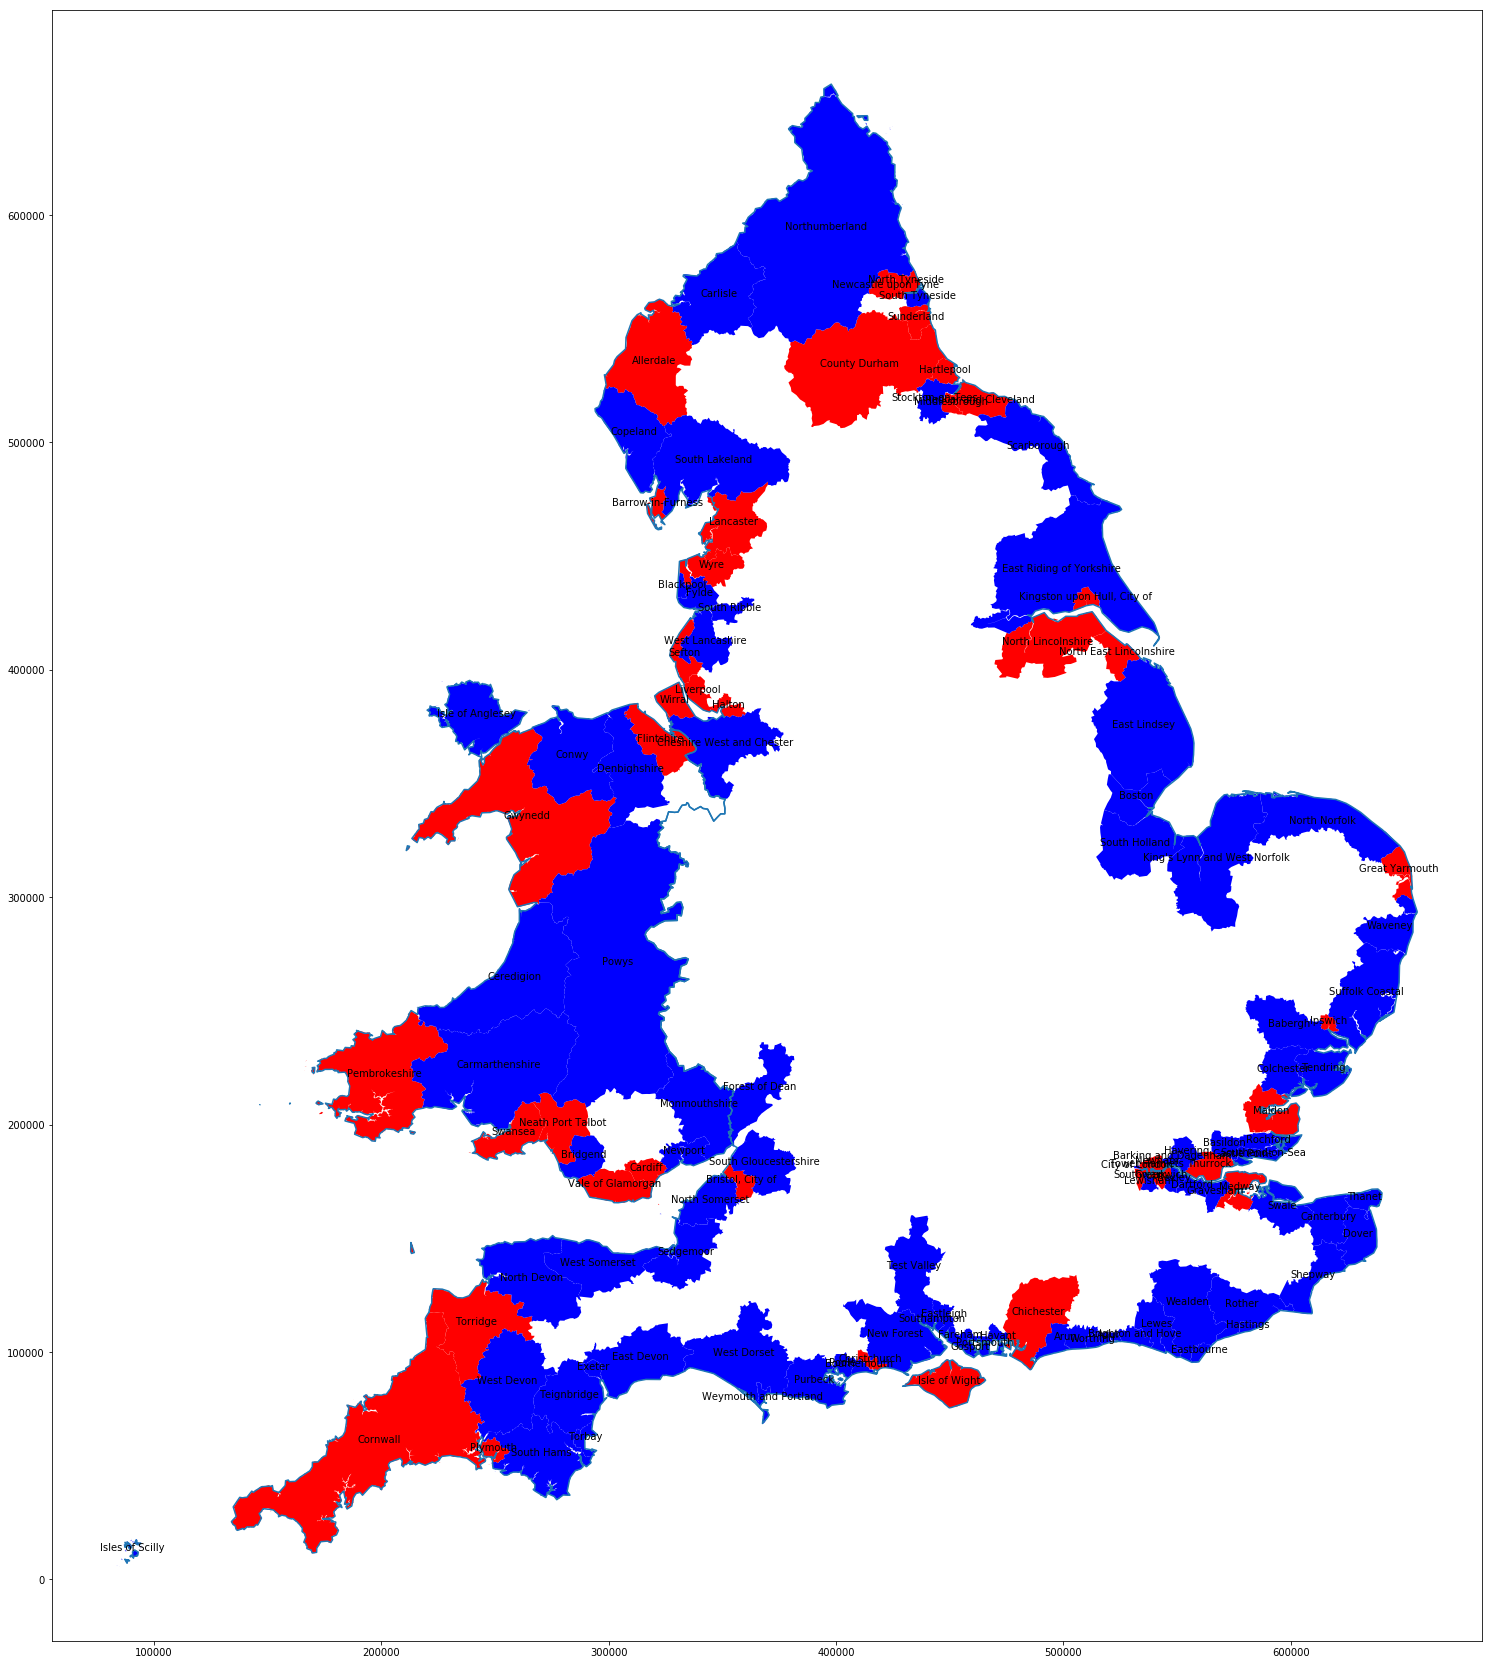

In [47]:
# labelled plot of coastal lads with docks vs coastal lads without docks
# lads with docks in red
ax = ew.boundary.plot(figsize=(30,30))
coastlad[(coastlad['LAD16CD'].isin(docks['LAD16CD'])) & (coastlad['LAD16CD'].isin(coastlads))].plot(ax=ax, color='Red')
coastlad[~(coastlad['LAD16CD'].isin(docks['LAD16CD'])) & (coastlad['LAD16CD'].isin(coastlads))].plot(ax=ax, color='Blue')
coastlad[coastlad['LAD16CD'].isin(coastlads)].drop_duplicates(subset='LAD16CD').apply(lambda x: ax.annotate(s=x.lad16nm, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)